In [1]:
import numpy as np
import math 
import tqdm
import matplotlib.pyplot as plt
import re

In [2]:
characters = list("0123456789+-/*=")
N = 8
len(characters) ** N

2562890625

In [3]:
def base_probas(N):
    """
    Returns a list of probabilities for each base character.
    """
    probas = np.ones((N, len(characters)))
    # # Higher proba on = at the end
    # probas[N-4:N-1, -1] = 3
    # probas[N-4, -1] = 2
    # # Lower proba on = at the beginning
    # probas[:3, -1] = 0.3
    # probas[3, -1] = 0.5
    # Signs as first and last character
    probas[0, 10:]=0
    probas[-1, 10:]=0
    # Sum to 1
    probas /= np.sum(probas, axis=1)[:, None]
    return probas

def plot(probas):
    for i in range(len(probas)):
        plt.bar(characters, probas[i, :])
        plt.xticks(range(len(characters)), characters)
        plt.title("Probas for base {}".format(i))
        plt.show()

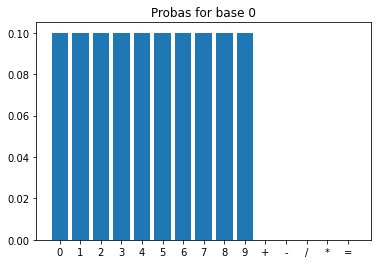

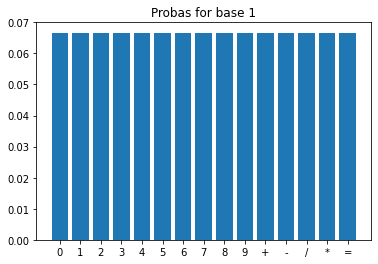

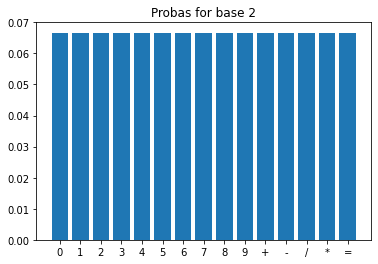

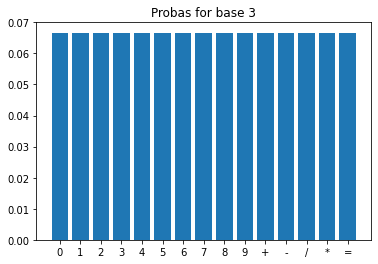

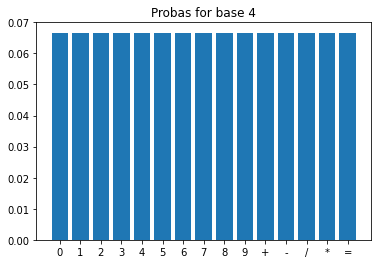

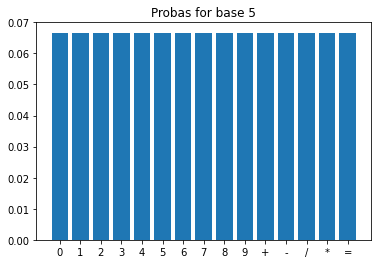

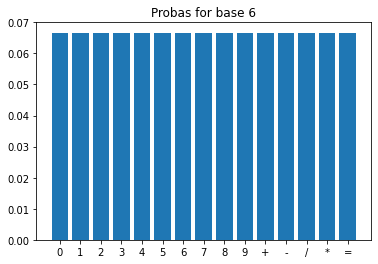

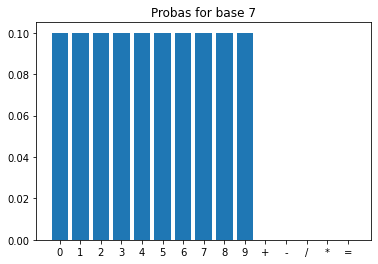

In [4]:
probas = base_probas(N)
plot(probas)

In [5]:
def split_by_operators(s):
    ops = ["+", "-", "*", "/"]
    for op in ops:
        s = s.replace(op, "SPLIT" + op + "SPLIT")
    return s.split("SPLIT")

def remove_leading_zeros(s):
    l = split_by_operators(s)
    for i in range(len(l)):
        try:
            l[i] = str(int(l[i]))
        except:
            pass
    return "".join(l)

def check_valid_args(s):
    for i in range(len(s)):
        c = s[i]
        if c in "+-/*":
            if i == 0 or i == len(s)-1:
                return False
            if s[i-1] in "+-/*" or s[i+1] in "+-/*":
                return False
    return True

In [6]:
max_nb_size = 2
max_operations = 1

def generate_random_expression(probas):
    """
    Generate a random expression of length N
    """
    N = len(probas)
    l = ""
    c = " "
    has_equal = False
    number_size = 0
    operations = 0
    for i in range(N):
        p = probas[i]
        if c in "+-/*=" or has_equal:
            # print(c, "No more signs")
            p[10:] = 0
        elif number_size >= max_nb_size:
            # print(c, "No more numbers")
            p[:10] = 0.001
        if operations == max_operations:
            # print(c, "No more operations")
            p[10:-1] = 0.001
        # Leading 0
        if c in "+-/*" or i == 0:
            p[0] = 0
        # sum p to 1
        p /= np.sum(p)
        # print(l, p)
        c = np.random.choice(characters, p=p)
        if c in "+-/*=":
            number_size = 0
            operations += 1
        else:
            number_size += 1
        # print(c)
        if c == "=":
            # print("Equal")
            has_equal = True
            r = eval(remove_leading_zeros(l))
            if isinstance(r, int) and len(str(r)) == N-i:
                l = f"{l}={r}"
                return l
        l += c
    # print(probas)
    return l
        

In [7]:
def random_int(probas, i):
    # lp = np.array([10, 90, 900])
    lp = np.array([1, 1, 1])
    lp = lp / np.sum(lp)
    length = np.random.choice(range(1, 4), p=lp)
    # length = min(length, len(probas)-i)
    s = 0
    for j in range(length):
        if i+j >= len(probas):
            break
        p = probas[i+j, :10]
        p /= np.sum(p)
        # print(p)
        n = np.random.choice(characters[:10], p=p)
        s = 10*s + int(n)
    return s 

In [8]:
probas = base_probas(N)
probas[2, 1:] = 0
random_int(probas, 0)

0

In [9]:
def generate_random(N, probas):
    max_number = 999
    # n = np.random.randint(max_number)
    n = random_int(probas, 0)
    l = str(n)
    for _ in range(3000):
        sign = np.random.choice(["+", "-", "*", "/"])
        # n = np.random.randint(1, max_number)
        n = random_int(probas, len(l))
        l = f"{l}{sign}{n}"
        try:
            val = eval(l)
        except:
            continue
        if val >0 and isinstance(val, int) and len(str(val)) + len(l) + 1 == N:
            # finish
            return f"""{l}={val}"""
        elif len(str(val)) + len(l) + 1 > N:
            # reset
            # n = np.random.randint(max_number)
            n = random_int(probas, 0)
            l = str(n)
        else:
            # continue
            pass
    raise Exception("Could not generate a valid expression")


In [145]:
probas = base_probas(N)
generate_random(8, probas)

Exception: Could not generate a valid expression

In [10]:
def check(s):
    # Has =
    if s.count("=")!= 1:
        return False
    l, r = s.split("=")
    # Both sides exist
    if l == "" or r == "":
        return False
    # Right side is a number
    if any(c in r for c in ["+", "-", "*", "/"]):
        return False
    # No leading zeros and valid opetators
    l = remove_leading_zeros(l)
    if check_valid_args(l) == False:
        return False
    r = remove_leading_zeros(r)
    if check_valid_args(r) == False:
        return False
    # Valid operations
    try:
        eval(l)
    except:
        return False
    # Valid number
    if not eval(l) == eval(r):
        return False
    return True

In [12]:
int(28.0) == 28.0

True

In [11]:
def complete(expression, N, probas):
    # Check if it's complete
    try:
        val = eval(expression)
    except:
        return []
    if val >= 0 and int(val)==val and len(f"{expression}={int(val)}") == N:
        # finish
        return [f"{expression}={int(val)}"]
    
    # Complete it
    L = []
    for c in ["+", "-", "*", "/"]:
        for i in range(999):
            e = f"{expression}{c}{i}"
            # print(e)
            if len(e) == N:
                if check(e):
                    L.append(e)
            elif len(e) < N:
                L += complete(e, N, probas)
            else:
                break
    return L

def generate_all(N, probas):
    bar = tqdm.tqdm(range(999))
    total = 0
    for i in bar:
        expressions = complete(str(i), N, probas)
        if len(expressions) > 0:
            total += len(expressions)
            with open("nerdle.csv", "a+") as file_object:
                text = "\n".join(expressions)+"\n"
                file_object.write(text)
        bar.set_description(f"{total} expressions")

In [22]:
probas = base_probas(N)
complete("100/5", N, probas)

['100/5=20']

In [24]:
probas = base_probas(N)
L = generate_all(N, probas)

0 expressions: 100%|██████████| 999/999 [02:43<00:00,  6.10it/s]    


In [12]:
import pandas
df = pandas.read_csv("nerdle.csv", header=None, names=["expression"])
df

,expression
0,0+0*10=0
1,0+0*11=0
2,0+0*12=0
3,0+0*13=0
4,0+0*14=0
...,...
39068,873/97=9
39069,882/9=98
39070,882/98=9
39071,891/9=99


In [128]:
L = []
probas = base_probas(N)
bar = tqdm.tqdm(range(batch))
for i in bar:
    s = generate_random(N)
    if check(s):
        L.append(s)
        # bar.set_description(f"Valid: {len(L)}/{i}")
    if len(L) >= batch:
        break
print(f"Valid: {len(L)}/{batch}")

100%|█████████▉| 1999/2000 [00:42<00:00, 47.12it/s]

Valid: 2000/2000


In [129]:
filters = [
    # ".........",
    ".*\*.*",
]
filtered_list = L
for f in filters:
    p = re.compile(f)
    filtered_list = [ s for s in filtered_list if p.match(s) ]
filtered_list

['79*2=158',
 '85*7=595',
 '9*84=756',
 '89*9=801',
 '47*9=423',
 '5*51=255',
 '8*55=440',
 '8*96=768',
 '4*52=208',
 '43*3=129',
 '6*56=336',
 '87*5=435',
 '3*57=171',
 '92*2=184',
 '49*8=392',
 '9*87=783',
 '97*5=485',
 '29*9=261',
 '90*7=630',
 '9*27=243',
 '21*7=147',
 '6*91=546',
 '83*8=664',
 '6*47=282',
 '3*85=255',
 '25*9=225',
 '2*96=192',
 '35*4=140',
 '75*7=525',
 '9*56=504',
 '94*5=470',
 '3*69=207',
 '86*9=774',
 '87*7=609',
 '6*59=354',
 '6*19=114',
 '3*97=291',
 '3*70=210',
 '88*9=792',
 '7*66=462',
 '64*9=576',
 '48*3=144',
 '59*7=413',
 '6*73=438',
 '3*70=210',
 '8*75=600',
 '9*71=639',
 '15*8=120',
 '4*54=216',
 '94*9=846',
 '7*77=539',
 '45*4=180',
 '4*46=184',
 '6*52=312',
 '28*6=168',
 '9*73=657',
 '3*47=141',
 '67*6=402',
 '79*5=395',
 '91*9=819',
 '2*81=162',
 '5*94=470',
 '56*8=448',
 '70*8=560',
 '9*25=225',
 '4*56=224',
 '98*3=294',
 '37*7=259',
 '89*9=801',
 '97*5=485',
 '8*83=664',
 '76*4=304',
 '6*32=192',
 '4*74=296',
 '3*55=165',
 '90*6=540',
 '4*26=104',

In [130]:
[i for i in L if "/" in i]

[]